In [1]:
%pylab inline
%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('/home/students/s277665/.conda/envs/baseEnv/lib/python3.7/site-packages')
sys.path.append("/Users/francescoparino/Researchs/Mac2Mic/Util/")
sys.path.append("./")

In [3]:
import pandas as pd
import numpy as np
import scipy as spy
import os
import copy
import pickle
import itertools

from glob import glob

import seaborn as sns
blues = np.array(sns.light_palette("blue"))[[-4,-1]]
purples = np.array(sns.light_palette("purple"))[[-4,-1]]

import matplotlib.patches as mpatches
from collections import Counter, defaultdict
from itertools import combinations

from tqdm import tqdm_notebook

import collections, functools, operator 
from bidict import bidict

from multiprocessing import Pool

In [4]:
from Covid_Lib_Data import readCovidDataset, readMorti
from Covid_Lib_Simulator import parameters, initialStates, oneStep

In [5]:
dictProvincieNS, dictRegionNS, orderedPROV, convertPROV_REG, nh, Whk, covidProv, covidRegion, covidRegionCum, covidRegionNew = readCovidDataset()
cvdRgDc_CUM, cvdRgDc_NEW = readMorti()

preDay = 23 #effective 20gg before
pre = pd.DataFrame((np.zeros((preDay, 20))), columns = cvdRgDc_CUM.columns, index=pd.date_range(cvdRgDc_CUM.index[0]-datetime.timedelta(preDay), periods=preDay, freq='1D'))
pre.loc["2020-02-21", "Lombardia"] = 1
pre.loc["2020-02-22", "Lombardia"] = 1
pre.loc["2020-02-23", "Lombardia"] = 4
pre.loc["2020-02-20", "Veneto"] = 1
pre = pre.cumsum()

cvdRgDc_CUM = cvdRgDc_CUM.append(pre).sort_index()
cvdRgDc_NEW = cvdRgDc_CUM.diff()

<AxesSubplot:>

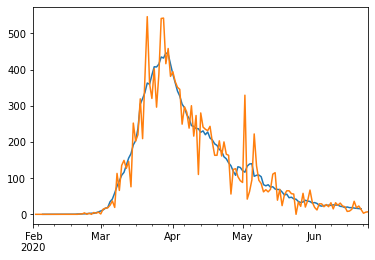

In [6]:
cvdRgDc_NEW["Lombardia"].rolling(7, center=True).mean().shift(0).dropna().plot(legend=False)
cvdRgDc_NEW["Lombardia"].plot(legend=False)

In [7]:
# Smooth
cvdRgDcRaw_NEW = cvdRgDc_NEW.copy().iloc[4:]
cvdRgDcRaw_CUM = cvdRgDc_CUM.copy().iloc[4:]
cvdRgDc_NEW = cvdRgDc_NEW.rolling(7, center=True).mean().dropna()
cvdRgDc_CUM = cvdRgDc_CUM.rolling(7, center=True).mean().dropna()

# Define Functions

In [8]:
def runTotal(SEINR, p, timeS=200, lockNord_b=None, lockSud_b=None, lockAll_alpha=None, smoothAlpha=True):
    S, E, I, N, R = SEINR
    
    time = np.arange(timeS)
    comSumForRegion = np.zeros((timeS, p.Whk.shape[0], 5))
    comSum = np.zeros((timeS, 5))
    rawSEINR = np.zeros((timeS, S.shape[0], p.Whk.shape[0], 5))
    
    
    # set and control alpha if negative
    if lockAll_alpha is not None:
        smoothDay = 15
        step = (1-p.alpha_lock)/smoothDay
        while lockAll_alpha < 0 and smoothDay>0: 
            print(f"Alpha Negative {lockAll_alpha}")
            lockAll_alpha += 1
            smoothDay -= 1
            p.alpha -= step
        
        
    # lockB negative
    if lockNord_b is not None:
        if lockNord_b < 0:  p.lockdown_b([dictProvincieNS[i] in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
    if lockSud_b is not None:
        if lockSud_b  < 0:  p.lockdown_b([dictProvincieNS[i] not in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
    

    for i in range(timeS):
        S, E, I, N, R = oneStep(SEINR,p) 
        
        rawSEINR[i] = np.dstack([S, E, I, N, R])
        comSumForRegion[i] = np.vstack([S.sum(0), E.sum(0), I.sum(0), N.sum(0), R.sum(0)]).transpose()
        comSum[i] = comSumForRegion[i].sum(0) #SEIAR
        SEINR = (S, E, I, N, R)
        
        if i == lockNord_b:
            p.lockdown_b([dictProvincieNS[i] in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
        if i == lockSud_b: 
            p.lockdown_b([dictProvincieNS[i] not in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
        
        
        if smoothAlpha:
            if i >= lockAll_alpha and i < (lockAll_alpha+smoothDay):
                p.alpha -= step
        else:
            if i == lockAll_alpha:
                p.lockdown_alpha()
            
    return time, comSum, comSumForRegion, rawSEINR

In [9]:
def getDataset(startDate, ggFit, initialEI_pos=-1, regionS=None):
    
    cvdRgDc_NEW_FIT = cvdRgDc_NEW[startDate: startDate + datetime.timedelta(days=ggFit)]
    cvdRgDc_CUM_FIT = cvdRgDc_CUM[startDate: startDate + datetime.timedelta(days=ggFit)]
    cvdRgDcRaw_NEW_FIT = cvdRgDcRaw_NEW[startDate: startDate + datetime.timedelta(days=ggFit)]
    cvdRgDcRaw_CUM_FIT = cvdRgDcRaw_CUM[startDate: startDate + datetime.timedelta(days=ggFit)]
    
    #Filter Regions
    if not regionS is None:
        cvdRgDc_CUM_FIT = cvdRgDc_CUM_FIT.loc[:, regionS]
        cvdRgDc_NEW_FIT = cvdRgDc_NEW_FIT.loc[:, regionS]
        cvdRgDcRaw_CUM_FIT = cvdRgDcRaw_CUM_FIT.loc[:, regionS]
        cvdRgDcRaw_NEW_FIT = cvdRgDcRaw_NEW_FIT.loc[:, regionS]
        
    #compute initial E,I
    initialCaseI = covidProv.iloc[initialEI_pos].values
    initialCaseE = covidProv.iloc[initialEI_pos].values
    
    realData = (cvdRgDc_CUM_FIT, cvdRgDc_NEW_FIT, cvdRgDcRaw_CUM_FIT, cvdRgDcRaw_NEW_FIT, initialCaseI, initialCaseE)
    return realData
    
    
def fToMin(inp, realData, ggFit, returnData=False, extraDay=0, norm=True, returnDataProv=False):
    cvdRgDc_CUM_FIT, cvdRgDc_NEW_FIT, cvdRgDcRaw_CUM_FIT, cvdRgDcRaw_NEW_FIT, initialCaseI, initialCaseE = realData
    Lambda, alpha_lock, b_lock, precentageE, precentageI = inp
    
    p = parameters(nh, Whk, Lambda=Lambda, alpha_lock=alpha_lock, b_lock=b_lock, precentageE=precentageE, precentageI=precentageI)    
    SEINR = initialStates(p, initialCaseI, initialCaseE)

    # run
    time, comSum, comSumForRegion, rawSEINR = runTotal(SEINR, p, ggFit+1+extraDay, lockNord_b, lockSud_b, lockAll_alpha, True)
    
    # crete timeseries from results
    mdlDc_CUM = pd.DataFrame((rawSEINR[:, :, :, 4] * p.mortality.reshape(1, 2, 1)).sum(1), columns=orderedPROV)
    mdlDc_CUM.index = pd.date_range(cvdRgDc_CUM_FIT.index[0], periods=len(mdlDc_CUM), freq='1D')     
    if returnDataProv: return mdlDc_CUM
    
    
    # rename axix to match dataset
    mdlRgDc_CUM = mdlDc_CUM.copy()
    mdlRgDc_CUM.columns = [convertPROV_REG[i] for i in mdlRgDc_CUM.columns]
    mdlRgDc_CUM = mdlRgDc_CUM.groupby(level=0, axis=1).sum()
    mdlRgDc_CUM = mdlRgDc_CUM[cvdRgDc_CUM_FIT.columns]
    mdlRgDc_NEW = mdlRgDc_CUM.diff()
    
    if not returnData:
        w = cvdRgDc_CUM_FIT.max(0)
        #mdlRgDc_CUM = mdlRgDc_CUM/cvdRgDc_CUM_FIT.max(0)
        #cvdRgDc_CUM_FIT = cvdRgDc_CUM_FIT/cvdRgDc_CUM_FIT.max(0)
        
        mdlRgDc_NEW = mdlRgDc_NEW/cvdRgDc_NEW_FIT.max()
        cvdRgDc_NEW_FIT = cvdRgDc_NEW_FIT/cvdRgDc_NEW_FIT.max()
        
        err = ((cvdRgDc_NEW_FIT - mdlRgDc_NEW)**2)
        return np.average(err.sum(0), weights=w)
        
        
    if returnData: 
        true_pred = pd.concat((cvdRgDcRaw_NEW_FIT.unstack(),mdlRgDc_NEW.unstack()), axis=1)
        true_pred.columns = ["true", "pred"]

        true_predCUM  = pd.concat((cvdRgDcRaw_CUM_FIT.unstack(),mdlRgDc_CUM.unstack()), axis=1)
        true_predCUM.columns = ["true", "pred"]
        return true_pred, true_predCUM
    
    



parOrder = ["Lambda", "alpha_lock", "b_lock", "initialE", "initialI"]
x0_default = [2.8, 0.2, 0, -3, -3]

def ident(bounds, startDate, ggFit, lockNord_b, lockSud_b, lockAll_alpha, initialEI_pos=-1, regionS=None, method="hop", x0=x0_default): 
    realData = getDataset(startDate, ggFit, initialEI_pos, regionS)
    f = functools.partial(fToMin, realData=realData, ggFit=ggFit)
    
    opt = spy.optimize.dual_annealing(f, bounds, maxiter=1000, initial_temp=3e4)

        
    print(f"error: {opt.fun:.3e}")
    print(",  ".join([f"{i}:{j:.3f}" for i,j in zip(parOrder, opt.x)]))
    
    return opt, opt.x

In [10]:
# Time Period Fit
initialEI_pos = -1
startDate = cvdRgDc_CUM.index[0]
ggFit = list(cvdRgDc_CUM.index).index(cvdRgDc_CUM.loc["2020-05-18"].name)

# Lock-down strategies
lockNord_b = (datetime.datetime(2020, 3, 1) - startDate).days
lockSud_b = (datetime.datetime(2020, 3, 7) - startDate).days
lockAll_alpha = (datetime.datetime(2020, 3, 5) - startDate).days

# Set bounds
bounds = ((0,2),        #Lambda
          (0,0.6),      #alpha_lock
          (0,1),        #b_lock
          (-10,1),      #initialE
          (-10,1))      #initialI

In [11]:
succ,par = ident(bounds, startDate, ggFit, lockNord_b, lockSud_b, lockAll_alpha, initialEI_pos=initialEI_pos, regionS=["Lombardia", "Piemonte", "Emilia-Romagna", "Veneto"], method="ann")

error: 3.082e+00
Lambda:0.042,  alpha_lock:0.177,  b_lock:0.000,  initialE:-3.606,  initialI:-2.102


In [12]:
parOrder = ["Lambda", "alpha_lock", "b_lock", "initialE", "initialI"]
print(dict(zip(parOrder, par)))

{'Lambda': 0.04218151748264074, 'alpha_lock': 0.17657372198907198, 'b_lock': 0.0, 'initialE': -3.6060057687708658, 'initialI': -2.1024724516951636}


In [13]:
#par1 = [0.043606755064603264, 0.17589789545466067, 0.0, -3.7113265987000714, -2.11379606705734]
#par2 = [0.03764876414731751, 0.1769411019701417, 0.0, -1.77331447029858, -9.999772179871798]

In [14]:
#realData = getDataset(startDate, ggFit, initialEI_pos=initialEI_pos, regionS=["Lombardia", "Piemonte", "Emilia-Romagna", "Veneto"])
#realData = getDataset(startDate, ggFit, initialEI_pos=initialEI_pos)
#print(fToMin(par2,realData, ggFit, extraDay = 0))

In [15]:
#realData = getDataset(startDate, ggFit, initialEI_pos=initialEI_pos, regionS=["Lombardia", "Piemonte", "Emilia-Romagna", "Veneto"])
#realData = getDataset(startDate, ggFit, initialEI_pos=initialEI_pos)
#print(fToMin(par1,realData, ggFit, extraDay = 0))

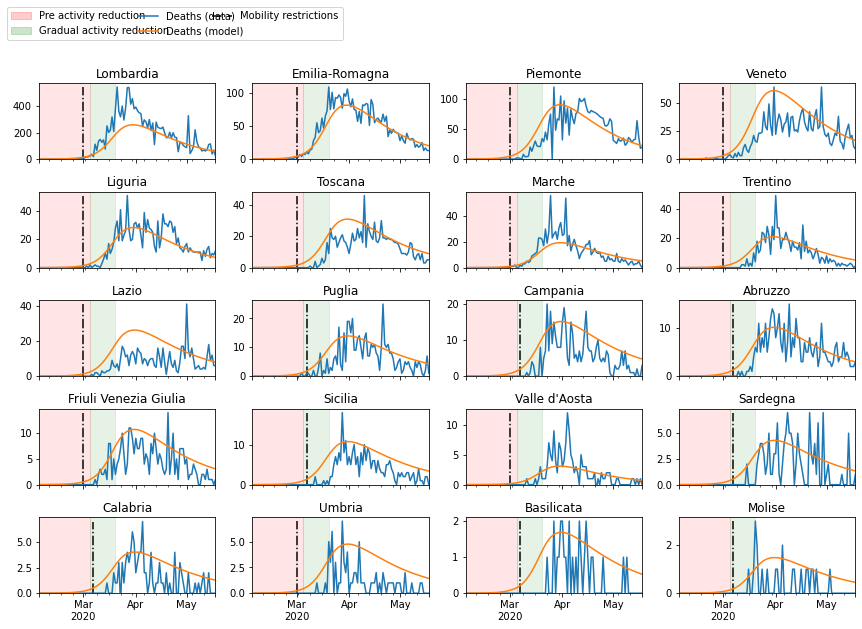

In [20]:
realData = getDataset(startDate, ggFit, initialEI_pos=initialEI_pos, regionS=["Lombardia", "Piemonte", "Emilia-Romagna", "Veneto"])
realData = getDataset(startDate, ggFit, initialEI_pos=initialEI_pos)

true_pred, true_predCUM = fToMin(par,realData, ggFit, returnData = True, extraDay = 0)
fig, axes = plt.subplots(5, 4, sharex=True, sharey=False, squeeze=False, figsize=(12, 8))
#fig, axes = plt.subplots(1, 1, sharex=True, sharey=False, squeeze=False, figsize=(10, 5))


cPre = "r"
cAlphaDec = "g"
cAlphaCos = "b"
cTrueNew = blues[0]
cPredNew = blues[1]
cTrueCum = purples[0]
cPredCum = purples[1]

mpPre      = mpatches.Patch(color=cPre, label='Pre activity reduction', alpha=0.2)
mpAlphaDec = mpatches.Patch(color=cAlphaDec, label='Gradual activity reduction', alpha=0.2)

mpTrueNew  = matplotlib.lines.Line2D([0], [0],color="C0", label='Deaths (data)', alpha=1)
mpPredNew  = matplotlib.lines.Line2D([0], [0],color="C1", label='Deaths (model)', alpha=1)

mpTrvlBn  = matplotlib.lines.Line2D([0], [0],color="black", label='Mobility restrictions', alpha=1, linestyle="dashdot")


i = 0
for r in reversed(realData[0].iloc[-1].sort_values().index):
    
    ax = axes[i//4, i%4]
    ax.set_title(r)
    
    
    true_pred.loc[r].true.plot(ax=ax, c="C0")
    true_pred.loc[r].pred.plot(ax=ax, c="C1")
    
    
    #ax2 = ax.twinx()
    #true_predCUM.loc[r].true.plot(ax=ax2, c=purples[0])
    #true_predCUM.loc[r].pred.plot(ax=ax2, c=purples[1])   
    
    ax.axvspan(startDate, startDate+datetime.timedelta(days=lockAll_alpha), alpha=0.1, color='r')
    ax.axvspan(startDate+datetime.timedelta(days=lockAll_alpha), startDate+datetime.timedelta(days=lockAll_alpha+15), alpha=0.1, color='g')
    ax.set_ylim(0, ax.get_ylim()[1])
    
    minDe = true_pred.loc[r].min().min()
    maxDe = true_pred.loc[r].max().max()
    if dictRegionNS[r] in {'Nord-ovest', 'Nord-est','Centro'}: ax.vlines(startDate+datetime.timedelta(lockNord_b), 0, maxDe, linestyles="dashdot", color="black")
    else: ax.vlines(startDate+datetime.timedelta(lockSud_b), 0, maxDe, linestyles="dashdot", color="black")
    
    i += 1
    #break
    
    
#plt.gca().legend(handles=[mpPre, mpAlphaDec, mpTrueNew, mpPredNew, mpTrueCum, mpPredCum], bbox_to_anchor=(0.68, 9.5))
fig.legend(handles=[mpPre, mpAlphaDec, mpTrueNew, mpPredNew, mpTrvlBn], bbox_to_anchor=(0,1.02,0.4,0.3), loc="lower left", mode="expand", ncol=3)
fig.tight_layout()
plt.savefig(f"./fitDeaths.pdf", bbox_inches = "tight")